In [168]:
import matplotlib.pyplot as plt
import numpy as np

In [90]:
def temperature2D(k = 1.0, row = 0.0, cp = 0.0, s = 1000.0e3, t = 1e2, delta_t = 1.0, e = 1e-3, temp = 100.0, \
                  q = 500.0e3, x_len = 0.4, y_len = 0.4, delta_x = 0.04, delta_y = 0.04):
    # setting up 2D grid
    x_dim    = int(x_len / delta_x)
    y_dim    = int(y_len / delta_y)
    grid_dim = (x_dim + 2, y_dim + 2) # grid dimensions with ghost cells

    T_grid = np.zeros((grid_dim))     # temperature grid with ghost cells

    # since flux at right wall is given, the temp. diff. at left side inner grid 
    # point and outer grid point can be calculated to satisfy the BC at left wall
    delta_T = q * delta_x / k

    # initialising the grid according to BCs
    T_grid[: 2, :] = 100.0
    T_grid[1: -1, 0] = T_grid[1: -1, 1] + delta_T
    T_grid[-1, :] = T_grid[-2, :]

    # extracting inner cells T values
    T_in_vals = T_grid[1: -1, 1: -1]
    
    # creating data structures for aP, aE, aW, aN, aS and b, a FVM representation
    aP = np.zeros((x_dim, y_dim))
    aP_0 = np.zeros((x_dim, y_dim))
    aE = np.zeros((x_dim, y_dim))
    aW = np.zeros((x_dim, y_dim))
    aN = np.zeros((x_dim, y_dim))
    aS = np.zeros((x_dim, y_dim))
    b = np.zeros((x_dim, y_dim))

    # calculating aE, aW, aN, aS, aP_0 and aP for all the inner points
    aE[:, : -1] = k * delta_y / delta_x
    aW[:, 1 :] = k * delta_y / delta_x
    aN[1 :, :] = k * delta_x / delta_y
    aS[: -1, :] = k * delta_x / delta_y

    aP_0[:, :] = row * cp * delta_x * delta_y / delta_t

    aP[:, :] = aE[:, :] + aW[:, :] + aN[:, :] + aS[:, :] + aP_0[:, :]

    # calculatiing source for all the inner points
    b[:, :] = s * delta_x * delta_y
    
    n = 0
    # solving for T in the 2D grid until convergence
    while True:
        n += 1
        # Re-arranging the equations in the form: -aNUN + aPUP - aSUS = u_source, where u_source = aEUE + aWUW + b
        # After re-arranging in the above form, equations are solved using TDMA scheme for every North-South direction
        # in the grid, sweeping from West to East.
        T_vals = T_in_vals.copy()
        T_source = np.zeros(y_dim)

        for cols in range(0, y_dim):

            # constructing T_tdma
            T_tdma = np.diag(aP[:, cols], k=0) + np.diag(-aN[1:, cols], k=-1) +\
                     np.diag(-aS[: -1, cols], k=1)
            if cols == 0:
                T_source[:] = b[:, cols] + aE[:, cols + 1] * T_in_vals[:, cols + 1]
            elif cols == y_dim - 1:
                T_source[:] = b[:, cols] + aW[:, cols - 1] * T_in_vals[:, cols - 1]
            else:
                T_source[:] = b[:, cols] + aE[:, cols + 1] * T_in_vals[:, cols + 1] +\
                              aW[:, cols - 1] * T_in_vals[:, cols - 1]

            # from BC:
            T_tdma[0, :] = 0.0
            T_tdma[0, 0] = 1.0
            T_source[0]  = temp

            # solving for T:
            T_solution = np.linalg.solve(T_tdma, T_source)

            T_in_vals[:, cols] = T_solution[:]

        residue = abs(T_vals[:, :] - T_in_vals[:, :])
        #print('************ Residue **************', '\n')
        #print(np.sum(residue), '\n')
        if np.sum(residue) < e:
            print('#### Convergence in ', n, ' iterations ####')
            break
    
    # updating T grid with solution
    T_grid[1: -1, 1: -1] = T_in_vals[:, :]
    
    # imposing BCs on updated T grid
    T_grid[: 2, :] = 100.0
    T_grid[1: -1, 0] = T_grid[1: -1, 1] + delta_T
    T_grid[-1, :] = T_grid[-2, :]
    T_grid[:, -1] = T_grid[:, -2]
    
    return T_grid, T_in_vals, x_dim, y_dim, x_len, y_len

In [91]:
def plot_2D_T_data(T_data, x_, y_):
    # plotting 2D data
    data = [
    go.Contour(
        z=T_data,
        x=x_,
        y=y_
    )]
    
    return data

In [137]:
def interpolated_data(T_data, T_innerData, x_dim, y_dim, x_len, y_len):
    # restructuring grid to accomodate interpolated data
    T_grid = np.zeros((x_dim * 2 + 1, y_dim * 2 + 1))
    
    # interpolation on all internal points
    T_grid[: : 2, 1: -1: 2] = (T_data[0: -1, 1: -1] + T_data[1:, 1: -1]) / 2.0
    T_grid[1: -1: 2, : : 2] = (T_data[1: -1, 0: -1] + T_data[1: -1, 1:]) / 2.0
    T_grid[1: -1: 2, 1: -1: 2] = T_innerData[:, :]
    T_grid[2: -1: 2, 2: -1: 2] = (T_grid[2: -1: 2, 1: -2: 2] + T_grid[2: -1: 2, 3: -1: 2] + \
                                  T_grid[1: -2: 2, 2: -1: 2,] + T_grid[3: -1: 2, 2: -1: 2]) / 4.0
    
    # interpolation on all boundary points excluding points on edges
    T_grid[2: -1: 2, 0] = (T_grid[1: -2: 2, 0] + T_grid[3: -1: 2, 0]) / 2.0
    T_grid[2: -1: 2, -1] = (T_grid[1: -2: 2, -1] + T_grid[3: -1: 2, -1]) / 2.0
    T_grid[0, 2: -1: 2] = (T_grid[0, 1: -2: 2] + T_grid[0, 3: -1: 2]) / 2.0
    T_grid[-1, 2: -1: 2] = (T_grid[-1, 1: -2: 2] + T_grid[-1, 3: -1: 2]) / 2.0
    
    # interpolation at edges
    T_grid[0, 0] = 100.0
    T_grid[0, -1] = 100.0
    T_grid[-1, -1] = T_grid[-2, -1]
    T_grid[-1, 0] = T_grid[-2, 0]
    
    # x and y axis interpolated data
    x = np.linspace(0., x_len, x_dim * 2 + 1)
    y = np.linspace(0., y_len, y_dim * 2 + 1)
    
    return T_grid, x, y

In [169]:
T_data, T_innerData, x_dim, y_dim, x_len, y_len = temperature2D(k = 1.0, row = 0.0, cp = 0.0, s = 1000.0e3, \
                                                                  t = 1e2, delta_t = 1.0, e = 1e-3, temp = 100.0, \
                                                                  q = 500.0e3, x_len = 0.4, y_len = 0.4, \
                                                                  delta_x = 0.08, delta_y = 0.08)

#### Convergence in  25  iterations ####


In [171]:
T_interpolated, x, y = interpolated_data(T_data, T_innerData, x_dim, y_dim, x_len, y_len)

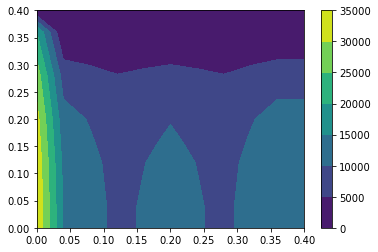

In [177]:
CS = plt.contourf(x, y, T_interpolated[::-1])
cbar = plt.colorbar(CS)
#cbar.ax.set_ylabel('Temperature distribution')
plt.show()